In [113]:
import pandas as pd
import matplotlib.pyplot as plt

In [114]:
df = pd.read_csv('prices-split-adjusted - Copy.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,05-01-16,WLTW,123.430000,125.839996,122.309998,126.250000,2163600
1,06-01-16,WLTW,125.239998,119.980003,119.940002,125.540001,2386400
2,07-01-16,WLTW,116.379997,114.949997,114.930000,119.739998,2489500
3,08-01-16,WLTW,115.480003,116.620003,113.500000,117.440002,2006300
4,11-01-16,WLTW,117.010002,114.970001,114.089996,117.330002,1408600


In [115]:
df.drop(['symbol', 'low', 'high', 'volume'], axis=1, inplace=True)
df.tail()

,date,open,close
246,23-12-16,123.089996,124.489998
247,27-12-16,124.570000,124.279999
248,28-12-16,124.300003,122.379997
249,29-12-16,122.449997,122.169998
250,30-12-16,122.589996,122.279999


In [116]:
# Convert the 'date' column to datetime format using the correct format string
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%y')


# Melt the DataFrame to create a 'price' column with 'open' and 'close' as types
df_melted = df.melt(id_vars=['date'], value_vars=['open', 'close'],
                    var_name='type', value_name='price')

# Sort the DataFrame by 'date'
df_sorted = df_melted.sort_values(by='date')

df_sorted.set_index('date', inplace=True)

# Drop the 'type' column if not needed
new_df = df_sorted.drop(columns=['type'])
new_df.reset_index(inplace=True)

# Display the final sorted DataFrame
print(new_df)

          date       price
0   2016-01-05  123.430000
1   2016-01-05  125.839996
2   2016-01-06  125.239998
3   2016-01-06  119.980003
4   2016-01-07  116.379997
..         ...         ...
497 2016-12-28  124.300003
498 2016-12-29  122.169998
499 2016-12-29  122.449997
500 2016-12-30  122.589996
501 2016-12-30  122.279999

[502 rows x 2 columns]


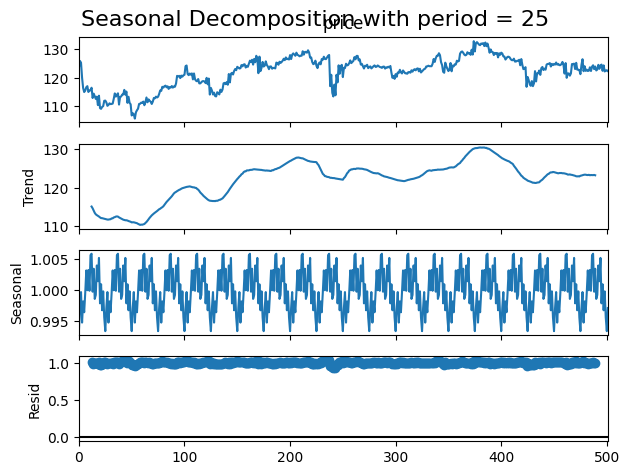

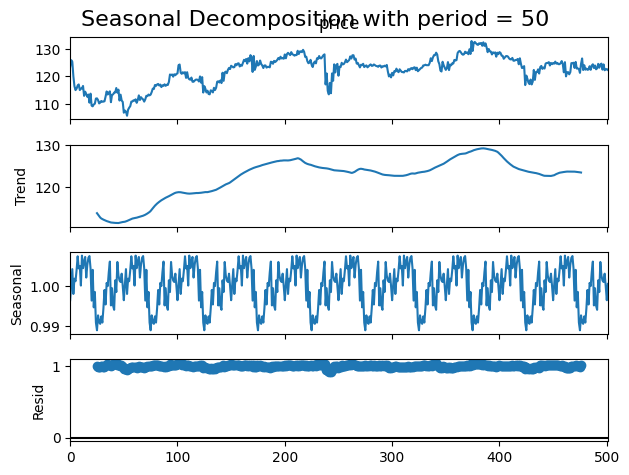

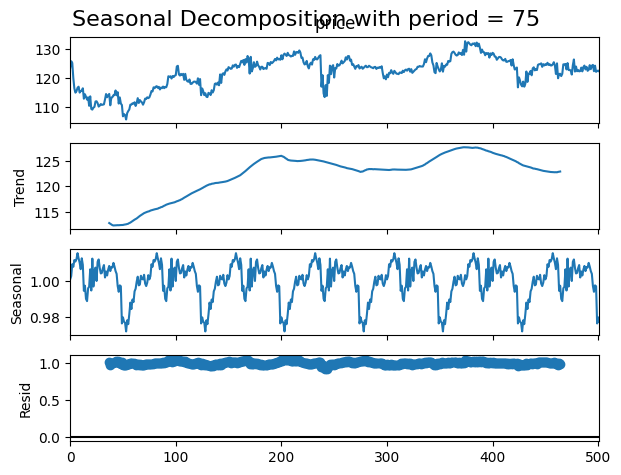

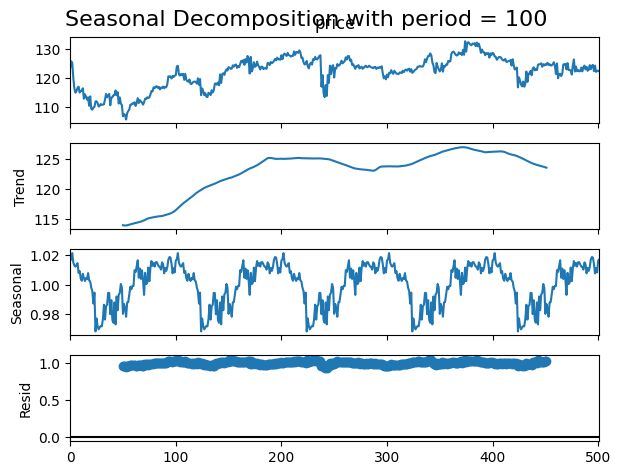

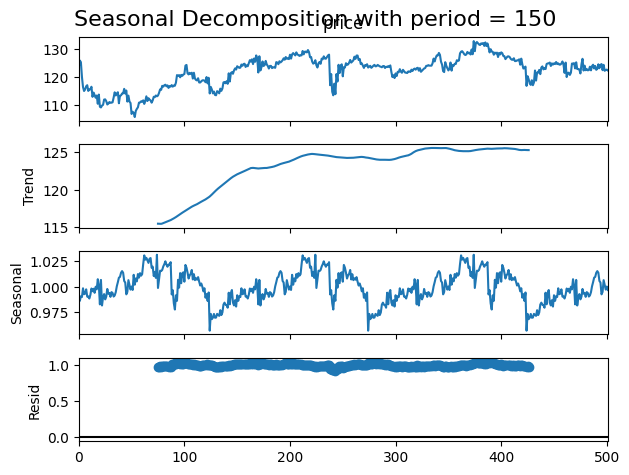

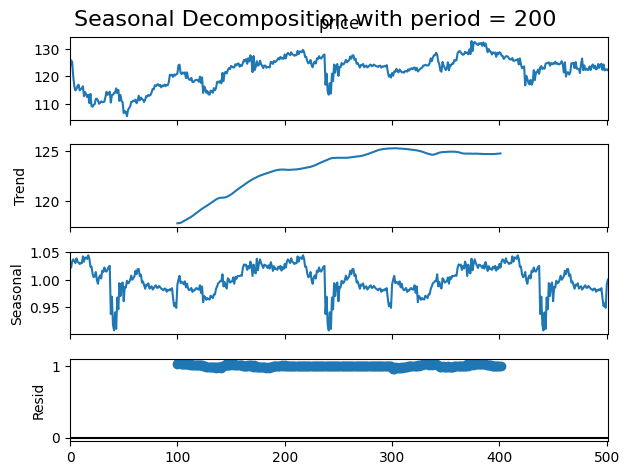

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose

periods = [25, 50, 75, 100, 150, 200]

# Loop through each period and decompose the series
for period in periods:
    decomposition = seasonal_decompose(new_df['price'], model='multiplicative', period=period)
    
    # Plot the decomposition
    fig = decomposition.plot()
    
    # Add a title to the plot to differentiate them
    fig.suptitle(f'Seasonal Decomposition with period = {period}', fontsize=16)
    
    # Show the plot
    plt.show()

In [118]:
new_df.head()

,date,price
0,2016-01-05,123.430000
1,2016-01-05,125.839996
2,2016-01-06,125.239998
3,2016-01-06,119.980003
4,2016-01-07,116.379997


In [119]:
index_train = new_df[new_df['date'] == '2016-12-01'].index[0]
new_df.drop('date', axis=1, inplace=True)

In [127]:
print(index_train)

460


In [120]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

# Make a forecasting frame
df_shift, y = make_forecasting_frame(new_df['price'], kind="price", max_timeshift=10, rolling_direction=1)


Rolling: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


In [121]:
from tsfresh.utilities.dataframe_functions import impute

X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute)

Feature Extraction: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [123]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [124]:
print("Original shape:", X_scaled.shape)
print("Reduced shape:", X_pca.shape)

Original shape: (501, 783)
Reduced shape: (501, 2)


In [126]:
print(X_pca)

[[17.99222522 62.40605021]
 [14.79739601 22.76297928]
 [15.02715924 14.55351955]
 ...
 [-2.61702803 -0.62772812]
 [-2.40495506 -0.33156326]
 [-2.4217176  -1.53671903]]


In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Split the PCA-transformed features and target values into training and test sets
X_train, X_test = X_pca[:index_train], X_pca[index_train:]
y_train, y_test = y[:index_train], y[index_train:]

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1.3374157521077201


In [139]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=100, epsilon=0.1)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1.336996077554334
